In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorizationPhaseTrans")
sys.path.append("/Users/binxuwang/Github/DiffusionMemorizationPhaseTrans/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone,UNetBlockStyleMLP_backbone_NoFirstNorm
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.img_patch_stats_analysis_lib import *
from core.gaussian_mixture_lib import GaussianMixture_torch
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionMemorizationPhaseTrans"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [2]:
def visualize_trajs(x_traj, t_steps, pnts, title): # x0hat_traj, samples, 
    scaling = 1 / (t_steps ** 2 + 1).sqrt()
    scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
    plt.figure(figsize=(8, 8))
    plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
            scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
    plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
    plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
    plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
    plt.axis("equal")
    plt.title(title)
    plt.legend()
    return plt.gcf()

In [3]:
import pandas as pd

# Compare generated data statistics with training data
def compute_data_statistics_comparison(generated_samples, train_data, title=""):
    """
    Compare mean and covariance of generated samples with training data.
    """
    # Compute statistics for generated data
    gen_mean = generated_samples.mean(dim=0)
    gen_cov = torch.cov(generated_samples.T, correction=1)
    
    # Compute statistics for training data
    train_mean = train_data.mean(dim=0)
    train_cov = torch.cov(train_data.T, correction=1)
    
    # Compute differences
    mean_diff = torch.norm(gen_mean - train_mean).item()
    cov_diff = torch.norm(gen_cov - train_cov, 'fro').item()
    
    # Compute relative errors
    mean_rel_error = mean_diff / torch.norm(train_mean).item()
    cov_rel_error = cov_diff / torch.norm(train_cov, 'fro').item()
    
    print(f"{title}")
    print(f"Mean L2 difference: {mean_diff:.6f}")
    print(f"Mean relative error: {mean_rel_error:.6f}")
    print(f"Covariance Frobenius difference: {cov_diff:.6f}")
    print(f"Covariance relative error: {cov_rel_error:.6f}")
    print("-" * 50)
    
    return {
        'mean_diff': mean_diff,
        'cov_diff': cov_diff, 
        'mean_rel_error': mean_rel_error,
        'cov_rel_error': cov_rel_error
    }


In [4]:
def create_training_progress_animation(sample_store, pnts, objective_name, train_steps=None, sparse_slice=slice(None, None, 5)):
    """Create frames for training progress animation.
    
    Args:
        sample_store: Dictionary with training step keys and sample data values
        pnts: Points for visualization
        objective_name: Name of the objective (e.g., "ESM", "DSM")
        train_steps: List of training steps to animate (if None, uses all keys)
    
    Returns:
        List of PIL Image frames
    """
    import matplotlib.animation as animation
    from matplotlib.animation import PillowWriter
    import io
    from PIL import Image
    
    if train_steps is None:
        train_steps = list(sample_store.keys())
    
    frames = []
    
    for train_step in train_steps:
        samples, x_traj, x0hat_traj, t_steps = sample_store[train_step]
        # Create frame
        title = f"{objective_name} to Delta GMM | step {train_step}"
        fig = visualize_trajs(x_traj[:, sparse_slice], t_steps, pnts, title)
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        frames.append(Image.open(buf))
        plt.close(fig)
    
    return frames

def save_training_gifs(frames_esm, filename, savedirs=[]):
    """Save training progress animations as GIFs."""
    # Save ESM GIF
    for folder in savedirs:
        frames_esm[0].save(join(folder, filename+".gif"), 
                           save_all=True, append_images=frames_esm[1:], 
                           duration=800, loop=0)

In [5]:
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone_NoFirstNorm

In [6]:
savedir = join(saveroot, "DSM_memorization_track_pilot")
os.makedirs(savedir, exist_ok=True)

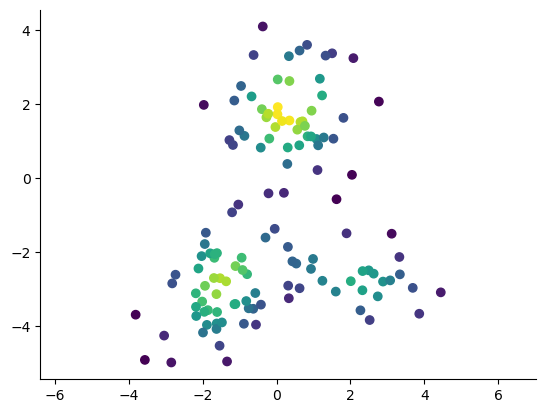

In [10]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
torch.manual_seed(42)
np.random.seed(42)

pnts, _, _ = gmm.sample(128)
density = gmm.pdf(pnts)
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis")
plt.axis("equal")
plt.show()
pnts_heldout, _, _ = gmm.sample(1000)
pnts_heldout_density = gmm.pdf(pnts_heldout)

  0%|          | 0/25000 [00:00<?, ?it/s]

step 0 loss 1.593
Step 1 | Train Loss: 1.4092 | Eval Loss: 1.3624
Step 2 | Train Loss: 1.2465 | Eval Loss: 1.2142
Step 3 | Train Loss: 1.1375 | Eval Loss: 1.1193
Step 4 | Train Loss: 1.1194 | Eval Loss: 1.0993
Step 5 | Train Loss: 1.0938 | Eval Loss: 1.0725
Step 6 | Train Loss: 1.0957 | Eval Loss: 1.0736
Step 7 | Train Loss: 1.1104 | Eval Loss: 1.0989
Step 8 | Train Loss: 1.1006 | Eval Loss: 1.0807
Step 9 | Train Loss: 1.1105 | Eval Loss: 1.1087
Step 10 | Train Loss: 1.1077 | Eval Loss: 1.0928
Step 20 | Train Loss: 0.9780 | Eval Loss: 1.0089
Step 30 | Train Loss: 0.9697 | Eval Loss: 0.9759
Step 40 | Train Loss: 0.9634 | Eval Loss: 0.9534
Step 50 | Train Loss: 0.9232 | Eval Loss: 0.9585
Step 60 | Train Loss: 0.9281 | Eval Loss: 0.9399
Step 70 | Train Loss: 0.9250 | Eval Loss: 0.9268
Step 80 | Train Loss: 0.9442 | Eval Loss: 0.9396
Step 90 | Train Loss: 0.9175 | Eval Loss: 0.9265
Step 100 | Train Loss: 0.9360 | Eval Loss: 0.9223
Step 200 | Train Loss: 0.8972 | Eval Loss: 0.9277
Step 300 

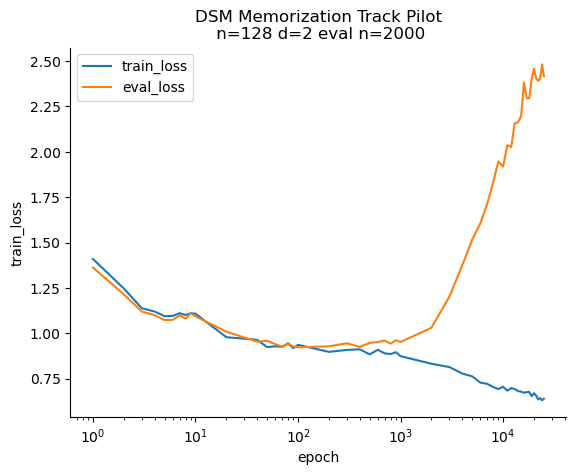

In [33]:
savedir = join(saveroot, "DSM_memorization_track_pilot_n128")
os.makedirs(savedir, exist_ok=True)
torch.manual_seed(42)
np.random.seed(42)
pnts, _, _ = gmm.sample(128)
pnts_heldout, _, _ = gmm.sample(2000)

record_step_list = [*range(0, 10, 1), *range(10, 100, 10), *range(100, 1000, 100), *range(1000, 10000, 1000), *range(10000, 25000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]

device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
pnts_heldout = pnts_heldout.to(device)
pnts = pnts.to(device)
eval_sample_num = 10000
repeats = (eval_sample_num + pnts.shape[0] - 1) // pnts.shape[0]
pnts_rep = torch.tile(pnts, (repeats, 1))[:eval_sample_num]
repeats = (eval_sample_num + pnts_heldout.shape[0] - 1) // pnts_heldout.shape[0]
pnts_heldout_rep = torch.tile(pnts_heldout, (repeats, 1))[:eval_sample_num]
# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
# train_loss_store = {}
# eval_loss_store = {}
train_stats_store = []
def eval_memorization_track_fn(epoch, loss, model, manual_seed=0):
    model.eval()
    with torch.no_grad():
        train_loss = edm_loss_fn(model, pnts_rep,)
        eval_loss = edm_loss_fn(model, pnts_heldout_rep,)
        # train_loss_store[epoch] = train_loss.mean().item()
        # eval_loss_store[epoch] = eval_loss.mean().item()
        train_stats_store.append({
            "epoch": epoch,
            "train_loss": train_loss.mean().item(),
            "eval_loss": eval_loss.mean().item(),
            "train_loss_std": train_loss.std().item(),
            "train_loss_sem": train_loss.std().item() / train_loss.shape[0] ** 0.5,
            "eval_loss_std": eval_loss.std().item(),
            "eval_loss_sem": eval_loss.std().item() / eval_loss.shape[0] ** 0.5,
        })
        print(f"Step {epoch} | Train Loss: {train_loss.mean().item():.4f} | Eval Loss: {eval_loss.mean().item():.4f}")
    model.train()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=25000, batch_size=2048, device=device, 
                                    callback=eval_memorization_track_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

train_stats_df = pd.DataFrame(train_stats_store)
train_stats_df.to_csv(join(savedir, "train_stats_store_dsm.csv"), index=False)
torch.save(train_stats_store, join(savedir, "train_stats_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))
plt.figure()
sns.lineplot(x="epoch", y="train_loss", data=train_stats_df, label="train_loss")
sns.lineplot(x="epoch", y="eval_loss", data=train_stats_df, label="eval_loss")
plt.legend()
plt.xscale("log")
plt.title(f"DSM Memorization Track Pilot\n n={pnts.shape[0]} d={ndim} eval n={pnts_heldout.shape[0]}")
saveallforms(savedir, "train_eval_loss_memorization_track_pilot", )
plt.show()

  0%|          | 0/25000 [00:00<?, ?it/s]

step 0 loss 1.470
Step 1 | Train Loss: 1.2800 | Eval Loss: 1.2587
Step 2 | Train Loss: 1.1278 | Eval Loss: 1.1479
Step 3 | Train Loss: 1.0677 | Eval Loss: 1.0881
Step 4 | Train Loss: 1.0683 | Eval Loss: 1.0868
Step 5 | Train Loss: 1.0634 | Eval Loss: 1.0744
Step 6 | Train Loss: 1.0785 | Eval Loss: 1.0754
Step 7 | Train Loss: 1.0790 | Eval Loss: 1.0684
Step 8 | Train Loss: 1.0598 | Eval Loss: 1.0550
Step 9 | Train Loss: 1.0507 | Eval Loss: 1.0616
Step 10 | Train Loss: 1.0383 | Eval Loss: 1.0392
Step 20 | Train Loss: 0.9701 | Eval Loss: 0.9916
Step 30 | Train Loss: 0.9569 | Eval Loss: 0.9544
Step 40 | Train Loss: 0.9518 | Eval Loss: 0.9454
Step 50 | Train Loss: 0.9260 | Eval Loss: 0.9513
Step 60 | Train Loss: 0.9268 | Eval Loss: 0.9367
Step 70 | Train Loss: 0.9358 | Eval Loss: 0.9382
Step 80 | Train Loss: 0.9401 | Eval Loss: 0.9396
Step 90 | Train Loss: 0.9247 | Eval Loss: 0.9351
Step 100 | Train Loss: 0.9469 | Eval Loss: 0.9269
Step 200 | Train Loss: 0.8949 | Eval Loss: 0.9093
Step 300 

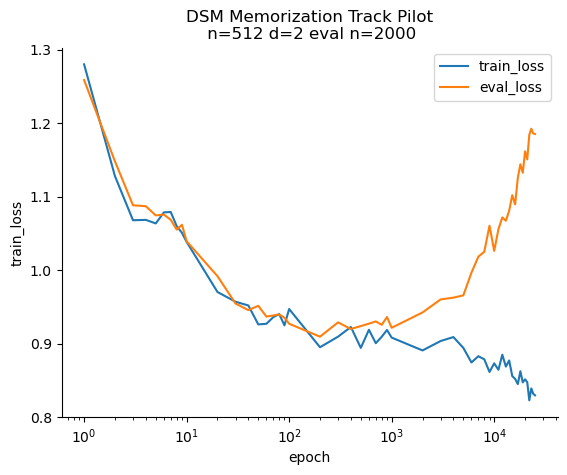

In [32]:
savedir = join(saveroot, "DSM_memorization_track_pilot_n512")
os.makedirs(savedir, exist_ok=True)
torch.manual_seed(42)
np.random.seed(42)
pnts, _, _ = gmm.sample(512)
pnts_heldout, _, _ = gmm.sample(2000)

record_step_list = [*range(0, 10, 1), *range(10, 100, 10), *range(100, 1000, 100), *range(1000, 10000, 1000), *range(10000, 25000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]

device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
pnts_heldout = pnts_heldout.to(device)
pnts = pnts.to(device)
eval_sample_num = 10000
repeats = (eval_sample_num + pnts.shape[0] - 1) // pnts.shape[0]
pnts_rep = torch.tile(pnts, (repeats, 1))[:eval_sample_num]
repeats = (eval_sample_num + pnts_heldout.shape[0] - 1) // pnts_heldout.shape[0]
pnts_heldout_rep = torch.tile(pnts_heldout, (repeats, 1))[:eval_sample_num]
# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
# train_loss_store = {}
# eval_loss_store = {}
train_stats_store = []
def eval_memorization_track_fn(epoch, loss, model, manual_seed=0):
    model.eval()
    with torch.no_grad():
        train_loss = edm_loss_fn(model, pnts_rep,)
        eval_loss = edm_loss_fn(model, pnts_heldout_rep,)
        # train_loss_store[epoch] = train_loss.mean().item()
        # eval_loss_store[epoch] = eval_loss.mean().item()
        train_stats_store.append({
            "epoch": epoch,
            "train_loss": train_loss.mean().item(),
            "eval_loss": eval_loss.mean().item(),
            "train_loss_std": train_loss.std().item(),
            "train_loss_sem": train_loss.std().item() / train_loss.shape[0] ** 0.5,
            "eval_loss_std": eval_loss.std().item(),
            "eval_loss_sem": eval_loss.std().item() / eval_loss.shape[0] ** 0.5,
        })
        print(f"Step {epoch} | Train Loss: {train_loss.mean().item():.4f} | Eval Loss: {eval_loss.mean().item():.4f}")
    model.train()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=25000, batch_size=2048, device=device, 
                                    callback=eval_memorization_track_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

train_stats_df = pd.DataFrame(train_stats_store)
train_stats_df.to_csv(join(savedir, "train_stats_store_dsm.csv"), index=False)
torch.save(train_stats_store, join(savedir, "train_stats_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))
plt.figure()
sns.lineplot(x="epoch", y="train_loss", data=train_stats_df, label="train_loss")
sns.lineplot(x="epoch", y="eval_loss", data=train_stats_df, label="eval_loss")
plt.legend()
plt.xscale("log")
plt.title(f"DSM Memorization Track Pilot\n n={pnts.shape[0]} d={ndim} eval n={pnts_heldout.shape[0]}")
saveallforms(savedir, "train_eval_loss_memorization_track_pilot", )
plt.show()

  0%|          | 0/25000 [00:00<?, ?it/s]

step 0 loss 1.394
Step 1 | Train Loss: 1.2241 | Eval Loss: 1.2418
Step 2 | Train Loss: 1.1281 | Eval Loss: 1.1368
Step 3 | Train Loss: 1.0859 | Eval Loss: 1.0911
Step 4 | Train Loss: 1.0814 | Eval Loss: 1.0834
Step 5 | Train Loss: 1.0643 | Eval Loss: 1.0576
Step 6 | Train Loss: 1.0523 | Eval Loss: 1.0498
Step 7 | Train Loss: 1.0560 | Eval Loss: 1.0482
Step 8 | Train Loss: 1.0321 | Eval Loss: 1.0252
Step 9 | Train Loss: 1.0336 | Eval Loss: 1.0408
Step 10 | Train Loss: 1.0394 | Eval Loss: 1.0273
Step 20 | Train Loss: 0.9656 | Eval Loss: 0.9758
Step 30 | Train Loss: 0.9634 | Eval Loss: 0.9551
Step 40 | Train Loss: 0.9592 | Eval Loss: 0.9349
Step 50 | Train Loss: 0.9325 | Eval Loss: 0.9463
Step 60 | Train Loss: 0.9435 | Eval Loss: 0.9435
Step 70 | Train Loss: 0.9387 | Eval Loss: 0.9414
Step 80 | Train Loss: 0.9434 | Eval Loss: 0.9336
Step 90 | Train Loss: 0.9327 | Eval Loss: 0.9295
Step 100 | Train Loss: 0.9436 | Eval Loss: 0.9251
Step 200 | Train Loss: 0.9046 | Eval Loss: 0.9104
Step 300 

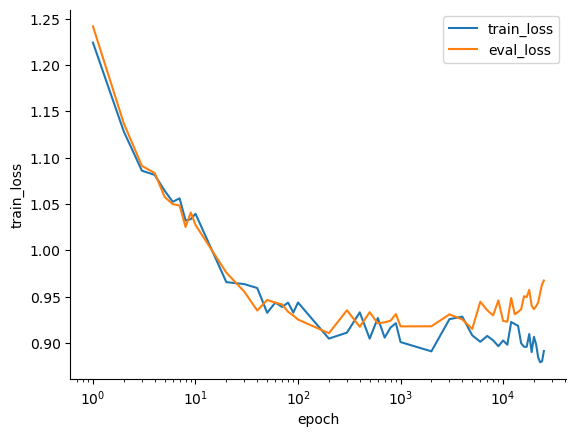

In [27]:
savedir = join(saveroot, "DSM_memorization_track_pilot_n1024")
os.makedirs(savedir, exist_ok=True)
torch.manual_seed(42)
np.random.seed(42)
pnts, _, _ = gmm.sample(1024)
pnts_heldout, _, _ = gmm.sample(2000)

record_step_list = [*range(0, 10, 1), *range(10, 100, 10), *range(100, 1000, 100), *range(1000, 10000, 1000), *range(10000, 25000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]

device = get_device()
sigma_data = pnts.std().item()
ndim = pnts.shape[1]
pnts_heldout = pnts_heldout.to(device)
pnts = pnts.to(device)
eval_sample_num = 10000
repeats = (eval_sample_num + pnts.shape[0] - 1) // pnts.shape[0]
pnts_rep = torch.tile(pnts, (repeats, 1))[:eval_sample_num]
repeats = (eval_sample_num + pnts_heldout.shape[0] - 1) // pnts_heldout.shape[0]
pnts_heldout_rep = torch.tile(pnts_heldout, (repeats, 1))[:eval_sample_num]
# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
# train_loss_store = {}
# eval_loss_store = {}
train_stats_store = []
def eval_memorization_track_fn(epoch, loss, model, manual_seed=0):
    model.eval()
    with torch.no_grad():
        train_loss = edm_loss_fn(model, pnts_rep,)
        eval_loss = edm_loss_fn(model, pnts_heldout_rep,)
        # train_loss_store[epoch] = train_loss.mean().item()
        # eval_loss_store[epoch] = eval_loss.mean().item()
        train_stats_store.append({
            "epoch": epoch,
            "train_loss": train_loss.mean().item(),
            "eval_loss": eval_loss.mean().item(),
            "train_loss_std": train_loss.std().item(),
            "train_loss_sem": train_loss.std().item() / train_loss.shape[0] ** 0.5,
            "eval_loss_std": eval_loss.std().item(),
            "eval_loss_sem": eval_loss.std().item() / eval_loss.shape[0] ** 0.5,
        })
        print(f"Step {epoch} | Train Loss: {train_loss.mean().item():.4f} | Eval Loss: {eval_loss.mean().item():.4f}")
    model.train()
    
model_dsm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=25000, batch_size=2048, device=device, 
                                    callback=eval_memorization_track_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

train_stats_df = pd.DataFrame(train_stats_store)
train_stats_df.to_csv(join(savedir, "train_stats_store_dsm.csv"), index=False)
torch.save(train_stats_store, join(savedir, "train_stats_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))
plt.figure()
sns.lineplot(x="epoch", y="train_loss", data=train_stats_df, label="train_loss")
sns.lineplot(x="epoch", y="eval_loss", data=train_stats_df, label="eval_loss")
plt.legend()
plt.xscale("log")
plt.show()

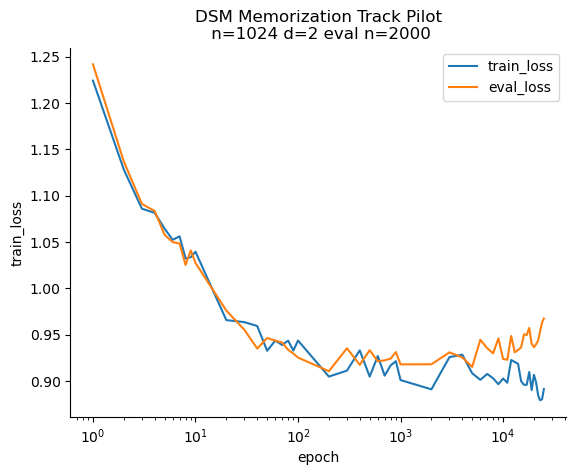

In [31]:
plt.figure()
sns.lineplot(x="epoch", y="train_loss", data=train_stats_df, label="train_loss")
sns.lineplot(x="epoch", y="eval_loss", data=train_stats_df, label="eval_loss")
plt.legend()
plt.xscale("log")
plt.title(f"DSM Memorization Track Pilot\n n={pnts.shape[0]} d={ndim} eval n={pnts_heldout.shape[0]}")
saveallforms(savedir, "train_eval_loss_memorization_track_pilot", )
plt.show()

### Summarize

In [34]:
train_stats_cmb = []
for n in [128, 512, 1024]:
    savedir = join(saveroot, f"DSM_memorization_track_pilot_n{n}")
    train_stats_df = pd.read_csv(join(savedir, "train_stats_store_dsm.csv"))
    train_stats_df["n"] = n
    train_stats_cmb.append(train_stats_df)
train_stats_cmb = pd.concat(train_stats_cmb)
# train_stats_cmb.to_csv(join(saveroot, "train_stats_store_dsm_cmb.csv"), index=False)
# print(f"n={n} | train_loss={train_stats_df['train_loss'].mean():.4f} | eval_loss={train_stats_df['eval_loss'].mean():.4f}")


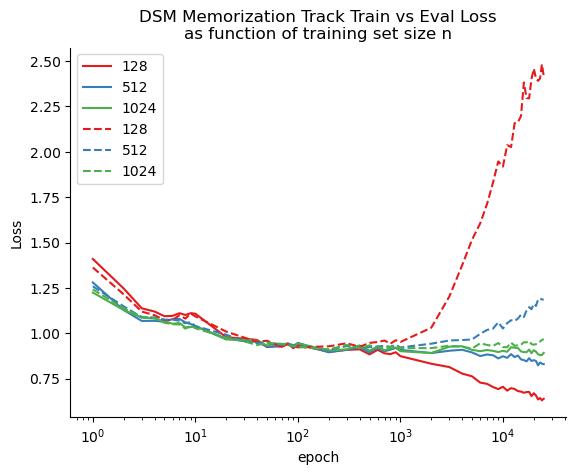

In [44]:
sns.lineplot(x="epoch", y="train_loss", data=train_stats_cmb, hue="n", palette="Set1", )#label=["train_loss128", "train_loss512", "train_loss1024"])
sns.lineplot(x="epoch", y="eval_loss", data=train_stats_cmb, hue="n", palette="Set1", linestyle="--", )#label=["eval_loss128", "eval_loss512", "eval_loss1024"])
plt.legend()
plt.ylabel("Loss")
plt.xscale("log")
plt.title("DSM Memorization Track Train vs Eval Loss\nas function of training set size n")
plt.show()

### Analysis

In [10]:
figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix"

In [12]:
import torch
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
for sigma in [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]:
    # Create multiple noised versions for better evaluation
    num_reps = 10
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_gmm = torch.mean((denoised_gmm - pnts_rep) ** 2)
    print(f"sigma: {sigma}\tMMSE of ESM - GMM: {mmse_esm.item():.5f}\tMMSE of DSM - GMM: {mmse_dsm.item():.5f}\tMMSE of GMM - X0: {mmse_gmm.item():.5f}")
    # print(f"MMSE of DSM: {mmse_dsm.item()}")

sigma: 0.002	MMSE of ESM - GMM: 0.00000	MMSE of DSM - GMM: 0.00000	MMSE of GMM - X0: 0.00000
sigma: 0.005	MMSE of ESM - GMM: 0.00003	MMSE of DSM - GMM: 0.00003	MMSE of GMM - X0: 0.00000
sigma: 0.01	MMSE of ESM - GMM: 0.00005	MMSE of DSM - GMM: 0.00009	MMSE of GMM - X0: 0.00000
sigma: 0.05	MMSE of ESM - GMM: 0.00012	MMSE of DSM - GMM: 0.00018	MMSE of GMM - X0: 0.00036
sigma: 0.1	MMSE of ESM - GMM: 0.00018	MMSE of DSM - GMM: 0.00028	MMSE of GMM - X0: 0.00354
sigma: 0.5	MMSE of ESM - GMM: 0.00015	MMSE of DSM - GMM: 0.00040	MMSE of GMM - X0: 0.19647
sigma: 1.0	MMSE of ESM - GMM: 0.00038	MMSE of DSM - GMM: 0.00129	MMSE of GMM - X0: 0.61784
sigma: 2.0	MMSE of ESM - GMM: 0.00063	MMSE of DSM - GMM: 0.00481	MMSE of GMM - X0: 1.74706
sigma: 5.0	MMSE of ESM - GMM: 0.00220	MMSE of DSM - GMM: 0.00660	MMSE of GMM - X0: 3.59384
sigma: 10.0	MMSE of ESM - GMM: 0.00793	MMSE of DSM - GMM: 0.02475	MMSE of GMM - X0: 4.30947
sigma: 20.0	MMSE of ESM - GMM: 0.02994	MMSE of DSM - GMM: 0.07726	MMSE of GMM - X0:

In [13]:
device = get_device()
pnts = pnts.to(device)
sigma = 1.0
stats_col = []
for sigma in np.logspace(np.log10(0.002), np.log10(100.0), 50):
    # Create multiple noised versions for better evaluation
    num_reps = 20
    # Create all noised points and sigma vectors at once
    pnts_rep = pnts.repeat(num_reps, 1)
    noised_pnts = pnts_rep + sigma * torch.randn(num_reps * pnts.shape[0], pnts.shape[1], device=device)
    sigma_vec = torch.full((num_reps * pnts.shape[0],), sigma, device=device)
    noised_pnts = noised_pnts.to(device)
    sigma_vec = sigma_vec.to(device)
    denoised_esm = model_precd_esm(noised_pnts, sigma_vec)
    denoised_esm2 = model_precd_esm2(noised_pnts, sigma_vec)
    denoised_dsm = model_precd_dsm(noised_pnts, sigma_vec)
    denoised_dsm2 = model_precd_dsm2(noised_pnts, sigma_vec)
    denoised_gmm = delta_GMM_denoiser(noised_pnts, pnts.to(device), sigma_vec[:, None])
    mmse_esm = torch.mean((denoised_esm - denoised_gmm) ** 2)
    mmse_esm2 = torch.mean((denoised_esm2 - denoised_gmm) ** 2)
    mmse_dsm = torch.mean((denoised_dsm - denoised_gmm) ** 2)
    mmse_dsm2 = torch.mean((denoised_dsm2 - denoised_gmm) ** 2)
    mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2)
    mmse_dsm_x0 = torch.mean((denoised_dsm - pnts_rep) ** 2)
    mmse_dsm2_x0 = torch.mean((denoised_dsm2 - pnts_rep) ** 2)
    stats_col.append({
        "sigma": sigma,
        "mmse_esm": mmse_esm.item(),
        "mmse_esm2": mmse_esm2.item(),
        "mmse_dsm": mmse_dsm.item(),
        "mmse_dsm2": mmse_dsm2.item(),
        "mmse_gmm_x0": mmse_gmm_x0.item(),
        "mmse_dsm_x0": mmse_dsm_x0.item(),
        "mmse_dsm2_x0": mmse_dsm2_x0.item(),
        })
stats_df = pd.DataFrame(stats_col)
stats_df.to_csv(join(savedir, "stats_col.csv"), index=False)

In [14]:
stats_df.loc[stats_df["mmse_esm"].idxmax(), "sigma"]

100.0

Text(0, 0.5, 'MMSE to GMM denoiser')

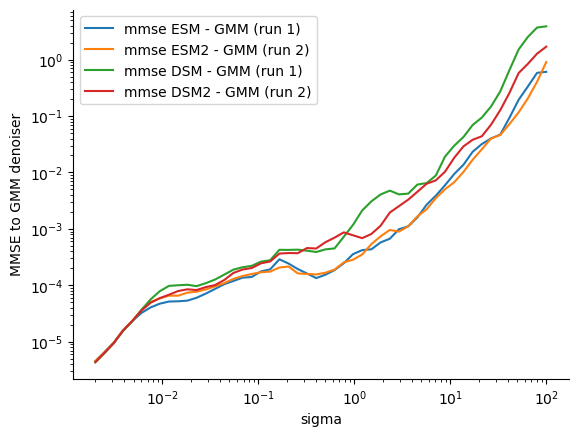

In [15]:
stats_df.plot(x="sigma", y=["mmse_esm", "mmse_esm2", "mmse_dsm", "mmse_dsm2", ], kind="line")
plt.legend(["mmse ESM - GMM (run 1)", "mmse ESM2 - GMM (run 2)","mmse DSM - GMM (run 1)", "mmse DSM2 - GMM (run 2)"])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("MMSE to GMM denoiser")

### Eval samples

In [16]:
sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
sample_store_dsm = torch.load(join(savedir, "sample_store_dsm.pth"))
sample_store_esm2 = torch.load(join(savedir, "sample_store_esm_2.pth"))
sample_store_dsm2 = torch.load(join(savedir, "sample_store_dsm_2.pth"))

/tmp/ipykernel_557711/1224902970.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
/tmp/ipykernel_5577

In [18]:
# Load the latest generated samples from ESM and DSM training
latest_step_esm = max(sample_store_esm.keys())
latest_step_dsm = max(sample_store_dsm.keys())
gen_samples_esm, _, _, _ = sample_store_esm[latest_step_esm]
gen_samples_dsm, _, _, _ = sample_store_dsm[latest_step_dsm]
# Also compare the two runs for each method
gen_samples_esm2, _, _, _ = sample_store_esm2[latest_step_esm]
gen_samples_dsm2, _, _, _ = sample_store_dsm2[latest_step_dsm]
# Compare statistics
stats_esm = compute_data_statistics_comparison(gen_samples_esm, pnts.cpu(), "ESM Generated vs Training Data:")
stats_esm2 = compute_data_statistics_comparison(gen_samples_esm2, pnts.cpu(), "ESM Run 2 Generated vs Training Data:")
stats_dsm = compute_data_statistics_comparison(gen_samples_dsm, pnts.cpu(), "DSM Generated vs Training Data:")
stats_dsm2 = compute_data_statistics_comparison(gen_samples_dsm2, pnts.cpu(), "DSM Run 2 Generated vs Training Data:")


# Create a dataframe with the statistics for comparison
stats_df = pd.DataFrame({
    'Method': ['ESM Run 1', 'ESM Run 2', 'DSM Run 1', 'DSM Run 2'],
    'Mean L2 Diff': [stats_esm['mean_diff'], stats_esm2['mean_diff'], 
                     stats_dsm['mean_diff'], stats_dsm2['mean_diff']],
    'Mean Rel Error': [stats_esm['mean_rel_error'], stats_esm2['mean_rel_error'],
                       stats_dsm['mean_rel_error'], stats_dsm2['mean_rel_error']],
    'Cov Frob Diff': [stats_esm['cov_diff'], stats_esm2['cov_diff'],
                      stats_dsm['cov_diff'], stats_dsm2['cov_diff']],
    'Cov Rel Error': [stats_esm['cov_rel_error'], stats_esm2['cov_rel_error'],
                      stats_dsm['cov_rel_error'], stats_dsm2['cov_rel_error']]
})

print("Data Statistics Comparison:")
print(stats_df.to_string(index=False, float_format='%.5f'))

ESM Generated vs Training Data:
Mean L2 difference: 0.085835
Mean relative error: 0.077744
Covariance Frobenius difference: 0.102572
Covariance relative error: 0.014875
--------------------------------------------------
ESM Run 2 Generated vs Training Data:
Mean L2 difference: 0.026171
Mean relative error: 0.023704
Covariance Frobenius difference: 0.045765
Covariance relative error: 0.006637
--------------------------------------------------
DSM Generated vs Training Data:
Mean L2 difference: 0.065143
Mean relative error: 0.059003
Covariance Frobenius difference: 0.144003
Covariance relative error: 0.020884
--------------------------------------------------
DSM Run 2 Generated vs Training Data:
Mean L2 difference: 0.049132
Mean relative error: 0.044501
Covariance Frobenius difference: 0.153247
Covariance relative error: 0.022224
--------------------------------------------------
Data Statistics Comparison:
   Method  Mean L2 Diff  Mean Rel Error  Cov Frob Diff  Cov Rel Error
ESM Run 1 

In [22]:
sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
sample_store_esm2 = torch.load(join(savedir, "sample_store_esm_2.pth"))
sample_store_dsm = torch.load(join(savedir, "sample_store_dsm.pth"))
sample_store_dsm2 = torch.load(join(savedir, "sample_store_dsm_2.pth"))
# Create frames for animation by going through different training steps
train_steps = list(sample_store_esm.keys())
# Create ESM frames
frames_esm = create_training_progress_animation(
    sample_store_esm, pnts, "Explicit Score Matching (run 1)", train_steps, sparse_slice=slice(None, None, 2)
)
frames_esm2 = create_training_progress_animation(
    sample_store_esm2, pnts, "Explicit Score Matching (run 2)", train_steps, sparse_slice=slice(None, None, 2)
)
# Create DSM frames  
frames_dsm = create_training_progress_animation(
    sample_store_dsm, pnts, "Normal Denoising Score Matching (EDM) (run 1)", train_steps, sparse_slice=slice(None, None, 2)
)
frames_dsm2 = create_training_progress_animation(
    sample_store_dsm2, pnts, "Normal Denoising Score Matching (EDM) (run 2)", train_steps, sparse_slice=slice(None, None, 2)
)
# Save the GIFs
save_training_gifs(frames_esm, "esm_training_progress_1")
save_training_gifs(frames_esm2, "esm_training_progress_2")
save_training_gifs(frames_dsm, "dsm_training_progress_1")
save_training_gifs(frames_dsm2, "dsm_training_progress_2")

print(f"Saved ESM training progress GIF to {join(figdir, 'esm_training_progress_1.gif')}")
print(f"Saved ESM training progress GIF to {join(figdir, 'esm_training_progress_2.gif')}")
print(f"Saved DSM training progress GIF to {join(figdir, 'dsm_training_progress_1.gif')}")
print(f"Saved DSM training progress GIF to {join(figdir, 'dsm_training_progress_2.gif')}")

/tmp/ipykernel_557711/121437247.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
/tmp/ipykernel_55771

Saved ESM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/esm_training_progress_1.gif
Saved ESM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/esm_training_progress_2.gif
Saved DSM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/dsm_training_progress_1.gif
Saved DSM training progress GIF to /n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs_final_fix/dsm_training_progress_2.gif


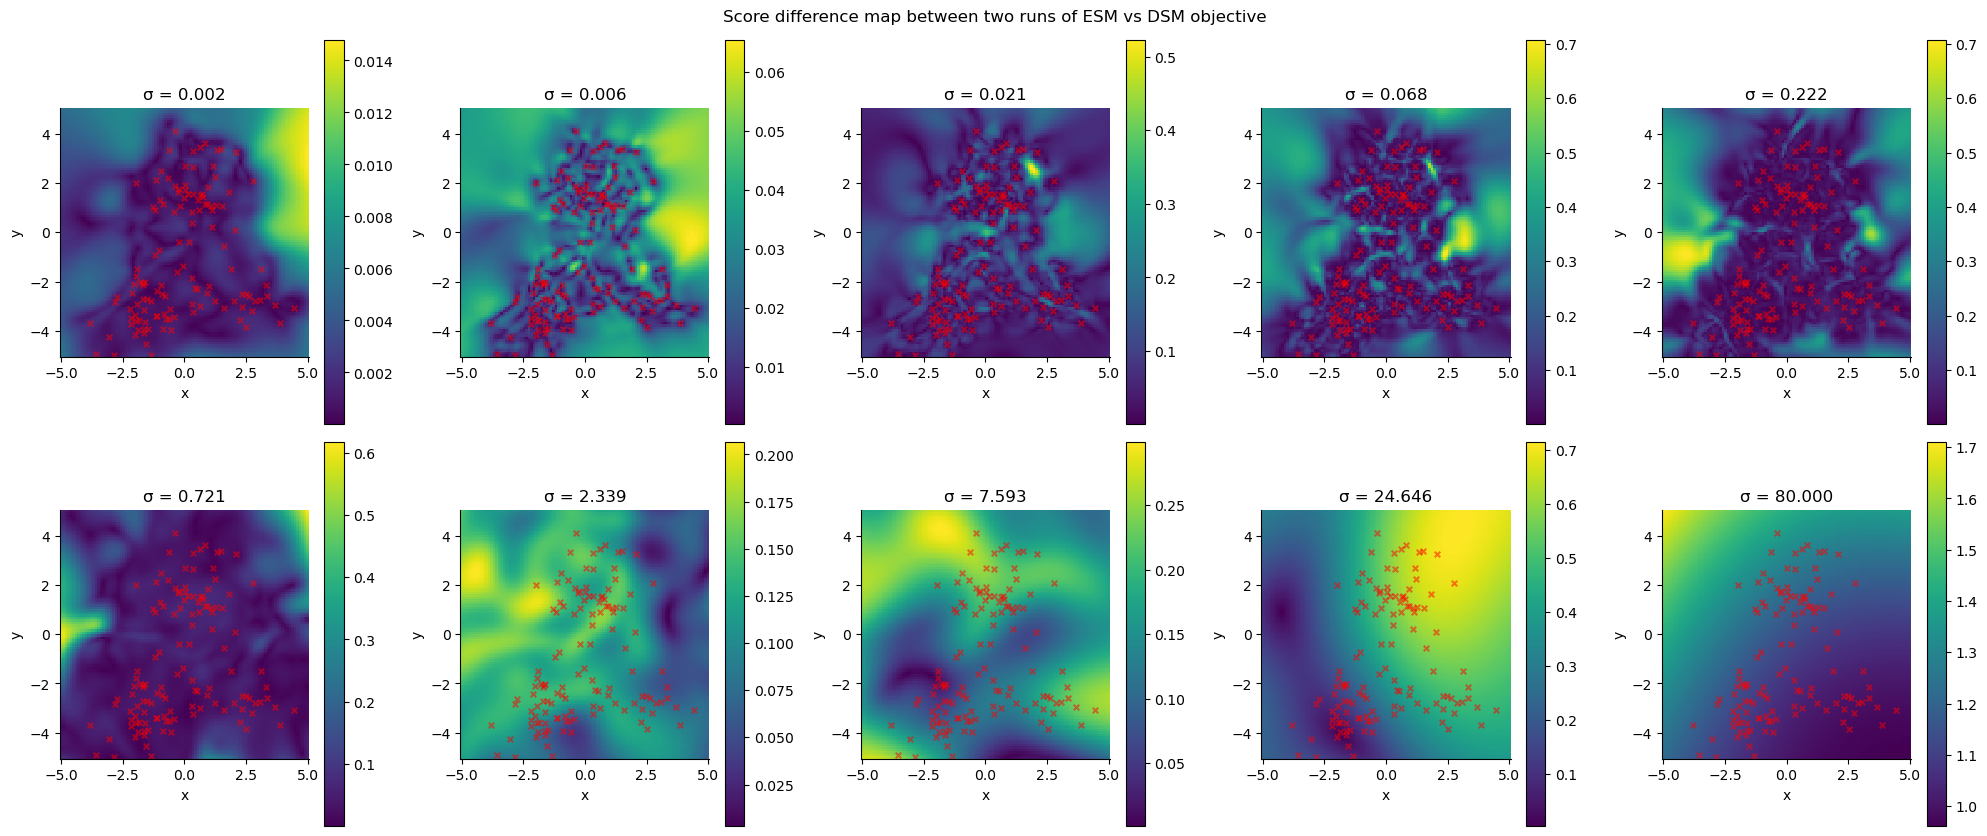

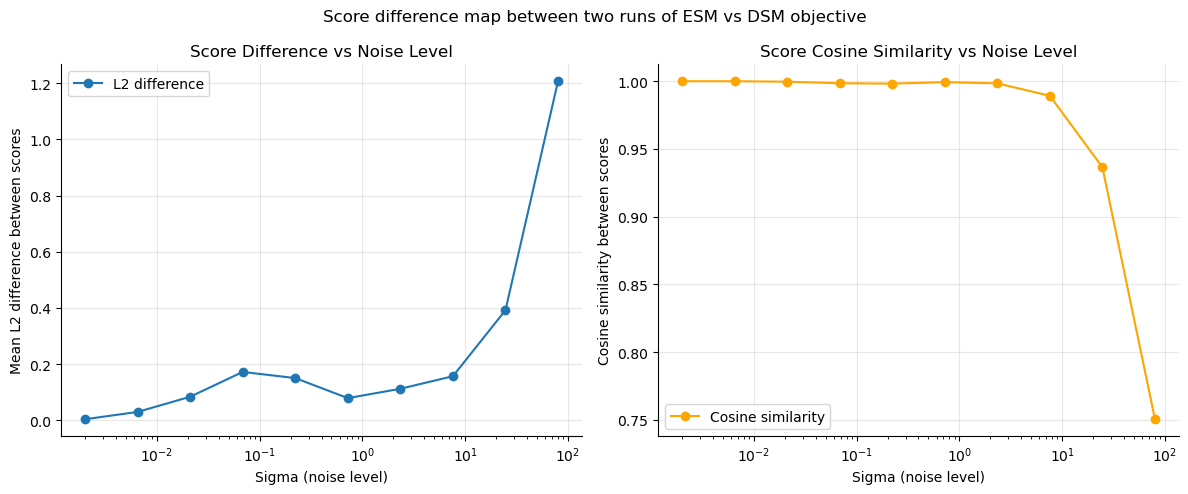

Average cosine similarity across noise levels: 0.9670
Average L2 difference across noise levels: 0.2384


In [28]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
cosine_similarities_at_each_point_col = []
model_precd_esm.eval()
model_precd_dsm.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_esm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_dsm(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # cosine similarity at each point
        cosine_similarities_at_each_point = torch.nn.functional.cosine_similarity(score1, score2, dim=1)
        cosine_similarities_at_each_point_col.append(cosine_similarities_at_each_point)
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of ESM vs DSM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of ESM vs DSM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  sigma[sigma == 0] = self.sigma_min
/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cuda/Indexing.cu:1561.)
  sigma[sigma == 0] = self.sigma_min


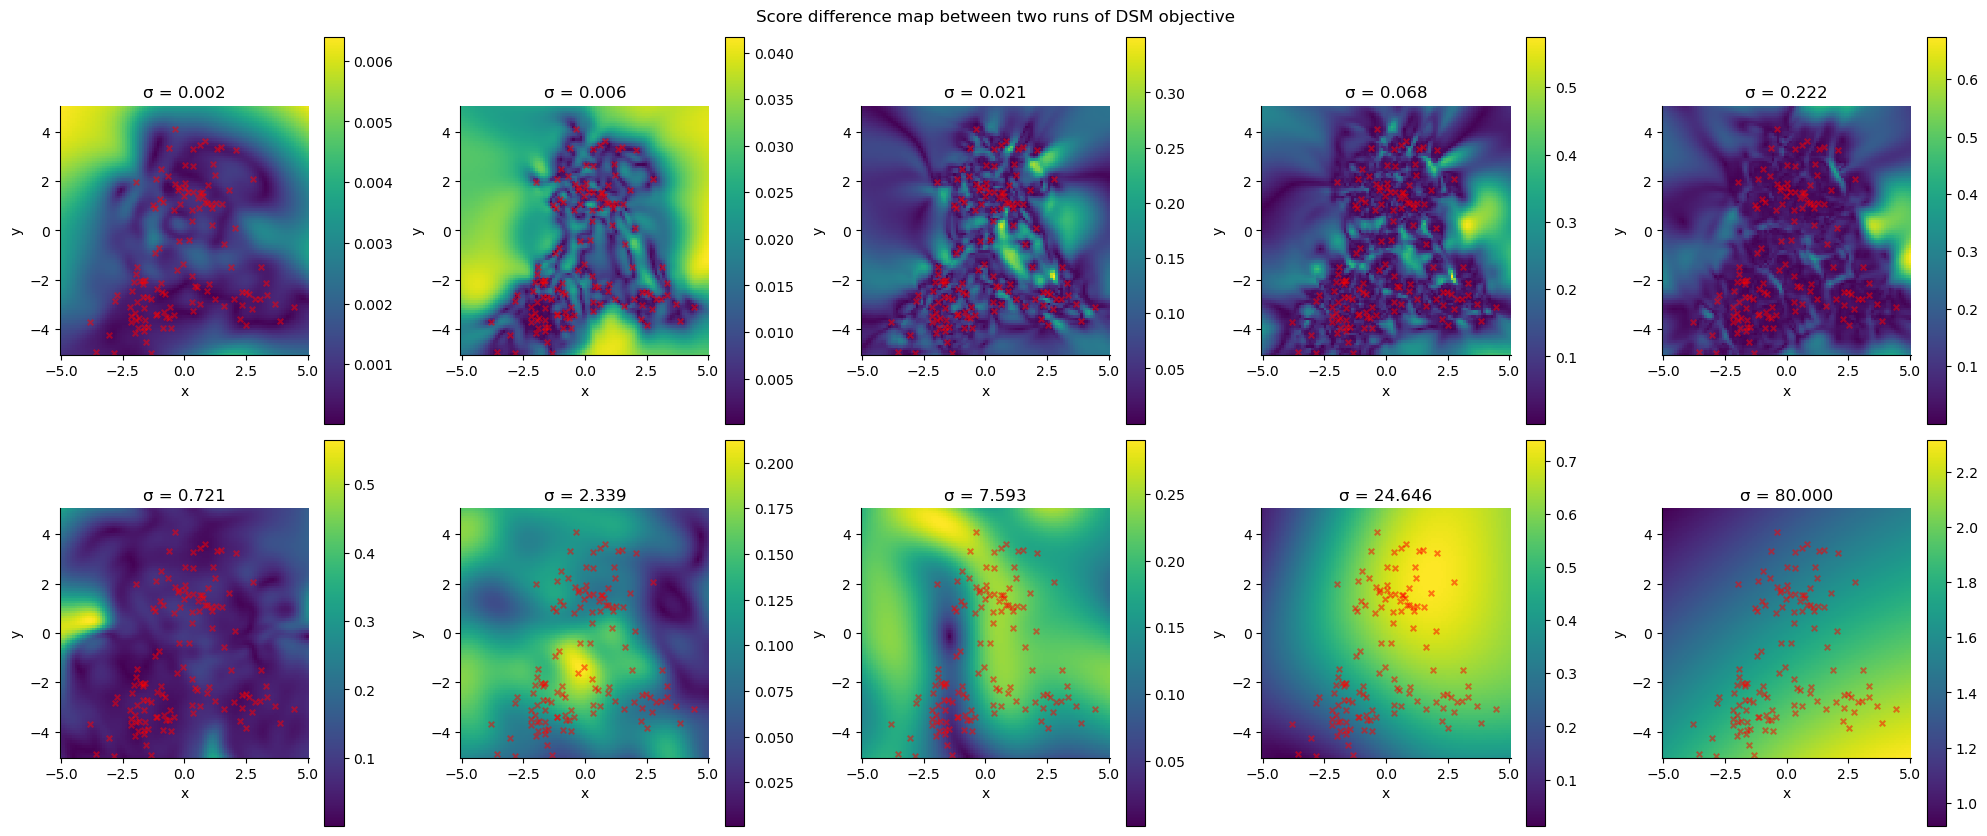

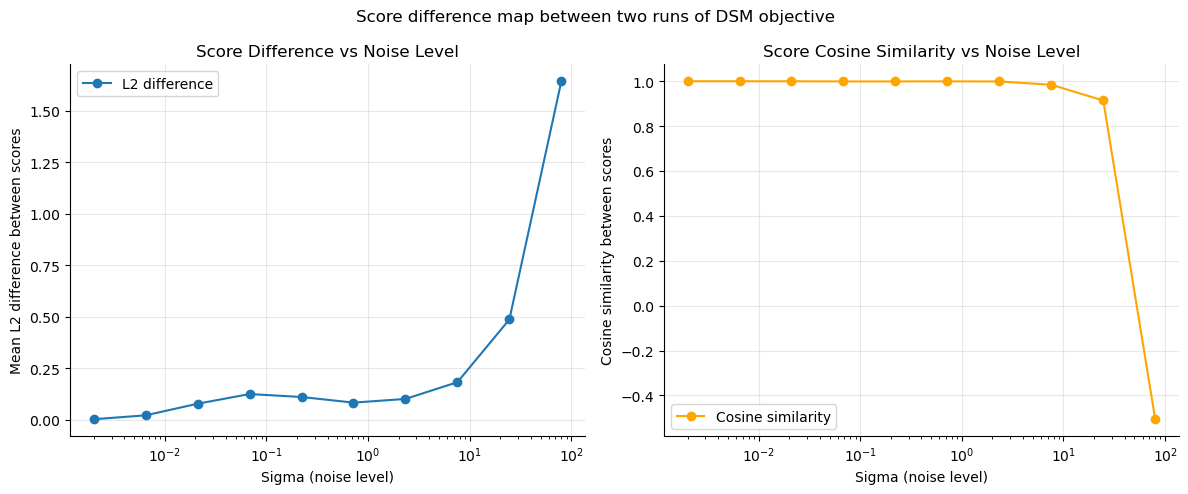

Average cosine similarity across noise levels: 0.8388
Average L2 difference across noise levels: 0.2829


In [26]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
model_precd_dsm.eval()
model_precd_dsm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_dsm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_dsm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of DSM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of DSM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


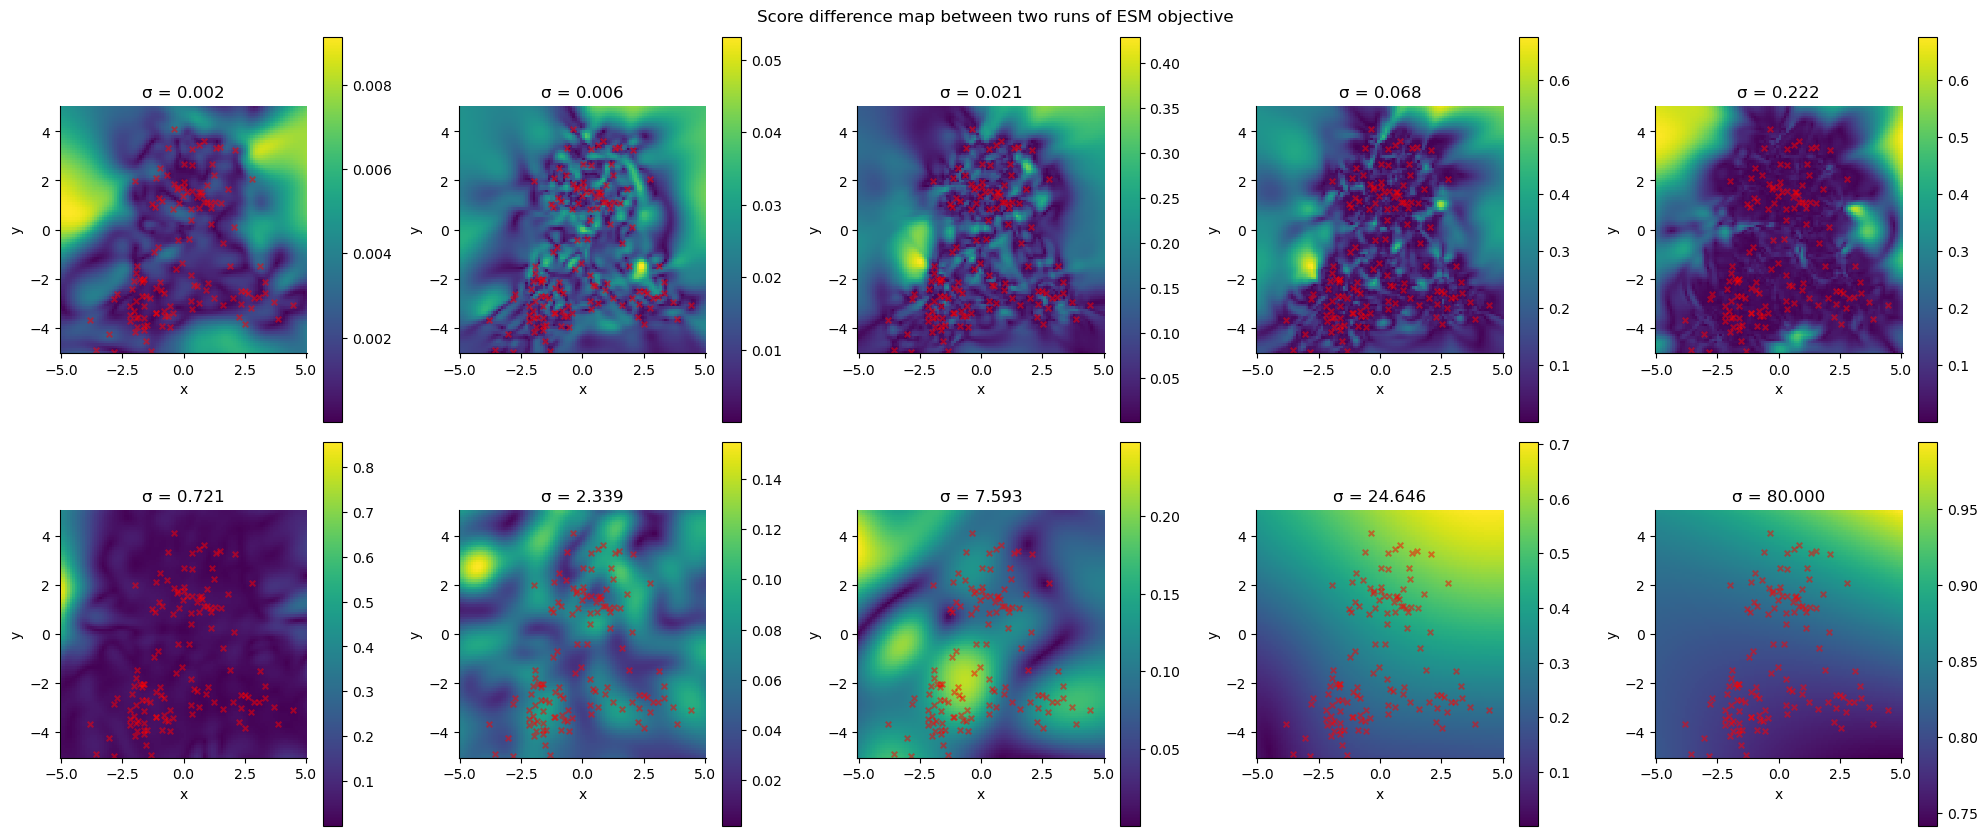

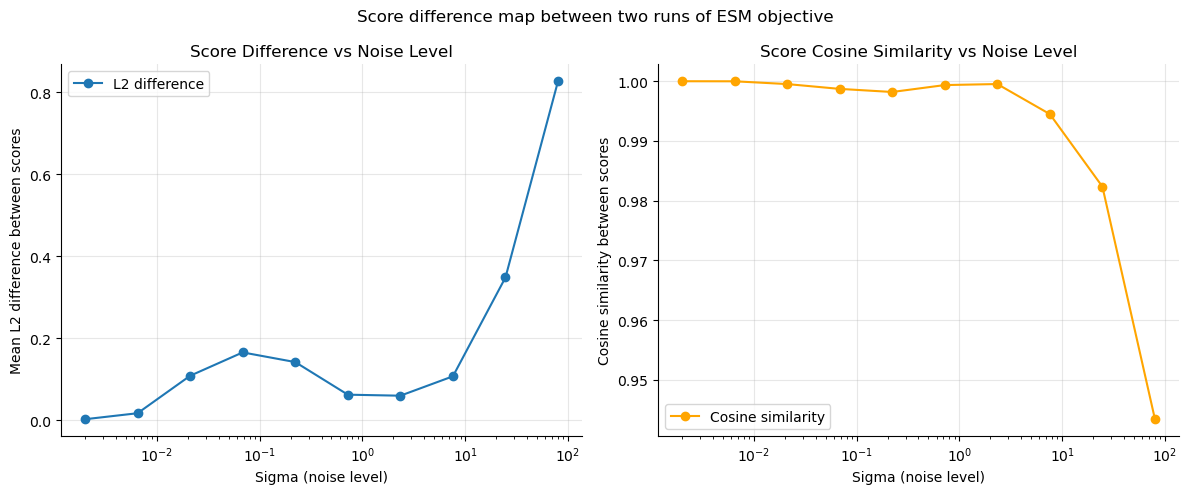

Average cosine similarity across noise levels: 0.9916
Average L2 difference across noise levels: 0.1844


In [27]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
cosine_similarities_at_each_point_col = []
model_precd_esm.eval()
model_precd_esm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_esm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_esm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # cosine similarity at each point
        cosine_similarities_at_each_point = torch.nn.functional.cosine_similarity(score1, score2, dim=1)
        cosine_similarities_at_each_point_col.append(cosine_similarities_at_each_point)
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(20, 8.5))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of ESM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of ESM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


### Measure sample generalization


In [35]:
record_step_list = list(sample_store_esm.keys())
# Collect all distance data for each method
min_dists_esm_all = []  # List of tensors, one per training step
min_dists_dsm_all = []
min_dists_2sample_esm_all = []  # Training data to samples
min_dists_2sample_dsm_all = []

for train_step in record_step_list:
    samples_esm, _, _, _ = sample_store_esm[train_step]
    samples_dsm, _, _, _ = sample_store_dsm[train_step]
    
    # Measure distance to closest training datapoint
    dists_esm = torch.cdist(samples_esm, pnts.cpu())  # [n_samples, n_train]
    min_dists_esm = dists_esm.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_esm = dists_esm.min(dim=0)[0]  # Distance to closest sample for each training point
    
    dists_dsm = torch.cdist(samples_dsm, pnts.cpu())  # [n_samples, n_train]
    min_dists_dsm = dists_dsm.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_dsm = dists_dsm.min(dim=0)[0]  # Distance to closest sample for each training point
    
    # Store raw distance data
    min_dists_esm_all.append(min_dists_esm)
    min_dists_dsm_all.append(min_dists_dsm)
    min_dists_2sample_esm_all.append(min_dists_2sample_esm)
    min_dists_2sample_dsm_all.append(min_dists_2sample_dsm)

# Compute statistics post-hoc
def compute_stats(dists_list):
    """Compute statistics for a list of distance tensors"""
    stats = []
    for dists in dists_list:
        stats.append({
            'mean': dists.mean().item(),
            'std': dists.std().item(),
            'min': dists.min().item(),
            'max': dists.max().item(),
            'q25': torch.quantile(dists, 0.25).item(),
            'q75': torch.quantile(dists, 0.75).item()
        })
    return stats

min_dists_esm_stats = compute_stats(min_dists_esm_all)
min_dists_dsm_stats = compute_stats(min_dists_dsm_all)
min_dists_2sample_esm_stats = compute_stats(min_dists_2sample_esm_all)
min_dists_2sample_dsm_stats = compute_stats(min_dists_2sample_dsm_all)

# Extract statistics for plotting
def extract_stat(stats_list, stat_name):
    """Extract a specific statistic from stats list"""
    return [stats[stat_name] for stats in stats_list]

esm_means = extract_stat(min_dists_esm_stats, 'mean')
esm_stds = extract_stat(min_dists_esm_stats, 'std')
esm_q25 = extract_stat(min_dists_esm_stats, 'q25')
esm_q75 = extract_stat(min_dists_esm_stats, 'q75')

dsm_means = extract_stat(min_dists_dsm_stats, 'mean')
dsm_stds = extract_stat(min_dists_dsm_stats, 'std')
dsm_q25 = extract_stat(min_dists_dsm_stats, 'q25')
dsm_q75 = extract_stat(min_dists_dsm_stats, 'q75')

esm_2sample_means = extract_stat(min_dists_2sample_esm_stats, 'mean')
esm_2sample_stds = extract_stat(min_dists_2sample_esm_stats, 'std')
esm_2sample_q25 = extract_stat(min_dists_2sample_esm_stats, 'q25')
esm_2sample_q75 = extract_stat(min_dists_2sample_esm_stats, 'q75')

dsm_2sample_means = extract_stat(min_dists_2sample_dsm_stats, 'mean')
dsm_2sample_stds = extract_stat(min_dists_2sample_dsm_stats, 'std')
dsm_2sample_q25 = extract_stat(min_dists_2sample_dsm_stats, 'q25')
dsm_2sample_q75 = extract_stat(min_dists_2sample_dsm_stats, 'q75')


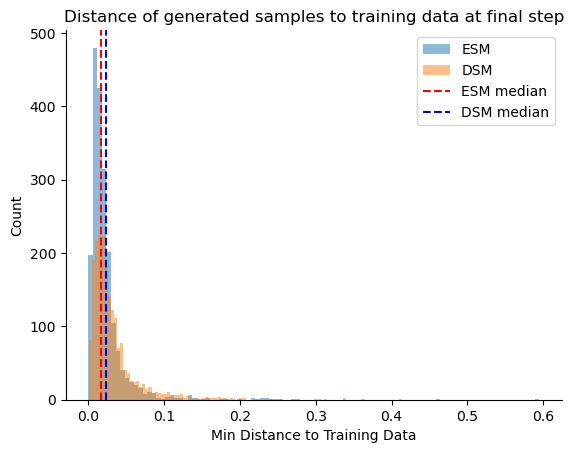

In [42]:
plt.hist(min_dists_esm_all[-1], bins=100, alpha=0.5, label="ESM")
plt.hist(min_dists_dsm_all[-1], bins=100, alpha=0.5, label="DSM")
plt.axvline(x=min_dists_esm_all[-1].median(), color="red", linestyle="--", label="ESM median")
plt.axvline(x=min_dists_dsm_all[-1].median(), color="blue", linestyle="--", label="DSM median")
plt.legend()
plt.xlabel("Min Distance to Training Data")
plt.ylabel("Count")
plt.title("Distance of generated samples to training data at final step")
plt.show()

In [ ]:
def delta_GMM_score(Xt, train_Xmat, sigma, return_weights=False):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    score = (torch.matmul(weights, train_Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_denoiser(Xt, train_Xmat, sigma):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    if isinstance(sigma, torch.Tensor):
        # Ensure sigma has the right shape for broadcasting
        if sigma.dim() == 0:
            # sigma is already a scalar, no change needed
            pass
        elif sigma.dim() == 1:
            sigma = sigma.unsqueeze(1)  # Shape becomes (k, 1)
        else:
            # For higher dimensional tensors, flatten to 1D then unsqueeze
            sigma = sigma.squeeze().unsqueeze(1)
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    # denoised = torch.matmul(weights, train_Xmat) # this is the original implementation
    # this is the more general implementation for tensors. 
    denoised = torch.matmul(weights, train_Xmat.flatten(1)).reshape(Xt.shape)
    return denoised

In [ ]:
class EDMDeltaGMMScoreLoss:
    def __init__(self, train_Xmat, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.train_Xmat = train_Xmat
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        # D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        # fixed July27
        D_gmm = delta_GMM_denoiser(X + n, self.train_Xmat, sigma)
        # loss = weight * ((D_yn - X) ** 2)
        loss = weight * ((D_yn - D_gmm) ** 2)
        return loss

In [ ]:

# torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))
# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

# record_step_list = [*range(0, 50000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
# device = get_device()
# ndim = pnts.shape[1]
# cov_empirical = torch.cov(pnts.T, correction=1)
# print(f"Point cloud dataset {pnts.shape[0]} samples, {ndim} features")
# model_esm = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
# model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
# model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
#                                     lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
#                                     callback=sampling_callback_fn, callback_freq=0, 
#                                     callback_step_list=record_step_list)
# torch.save(loss_traj_esm, join(savedir, "loss_traj_esm.pth"))
# torch.save(sample_store, join(savedir, "sample_store_esm.pth"))
# torch.save(model_precd_esm, join(savedir, "model_precd_esm.pth"))

# sample_store = {}
# loss_store = {}
# def sampling_callback_fn(epoch, loss, model, manual_seed=0):
#     loss_store[epoch] = loss
#     noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
#     x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
#                     num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
#     sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

# model_esm2 = UNetBlockStyleMLP_backbone_NoFirstNorm(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
# model_precd_esm2 = EDMPrecondWrapper(model_esm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
# model_precd_esm2, loss_traj_esm2 = train_score_model_custom_loss(pnts, model_precd_esm2, edm_delta_gmm_loss_fn, 
#                                     lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
#                                     callback=sampling_callback_fn, callback_freq=0, 
#                                     callback_step_list=record_step_list)
# torch.save(loss_traj_esm2, join(savedir, "loss_traj_esm_2.pth"))
# torch.save(sample_store, join(savedir, "sample_store_esm_2.pth"))
# torch.save(model_precd_esm2, join(savedir, "model_precd_esm_2.pth"))

